# Wasserstein gradient flow of interaction functionals
This notebook explores a toy example of Wasserstein gradient flows for an interaction functional built from Maximum Mean Discrepancy (MMD) toward a target measure.

**Warning:** The long-time behavior of the flow and its ability to reach a global minimum is a delicate subject. In addition, because the kernels used here are not smooth at the origin (these choices tend to work well in practice), the simulation should be viewed cautiously. It is not an exact implementation of the Wasserstein flow, since the true flow would not preserve discreteness of the measure along time.

**Value of $p$:** You may experiment with any $0<p<2$ in the definition of the kernel. Note that the kernel ceases to be definite when $p=2$ (the associated flow acts only through translation of the center of mass) and loses positivity for $p>2$. The case $p=1$ corresponds to the classical [Energy Distance](https://en.wikipedia.org/wiki/Energy_distance). These give negative homogeneous Sobolev metrics.

**Things to try:** You may change the kernel, for example test Laplacian or Gaussian interactions (be aware that Gaussian choices often produce proof convergence profile). You may also switch to more complex mixtures or explore point clouds in three dimensions.


Given a symmetric kernel $k : \mathbb{R}^d \times \mathbb{R}^d \to \mathbb{R}$, the squared Maximum Mean Discrepancy (MMD) between
two probability measures $\alpha$ and $\beta$ is defined by
$$
  \mathrm{MMD}(\alpha,\beta)^2
  := \iint k(x,y)\, \mathrm{d}(\alpha-\beta)(x)\, \mathrm{d}(\alpha-\beta)(y).
$$

In the discrete setup, we consider empirical measures
$$
  \alpha = \frac{1}{n} \sum_{i=1}^n \delta_{x_i},
  \qquad
  \beta  = \frac{1}{m} \sum_{j=1}^m \delta_{y_j},
$$
where $x_i, y_j \in \mathbb{R}^d$. Then
$$
  \mathrm{MMD}(\alpha,\beta)^2
  = \frac{1}{n^2} \sum_{i,j=1}^n k(x_i,x_j)
  + \frac{1}{m^2} \sum_{i,j=1}^m k(y_i,y_j)
  - \frac{2}{nm} \sum_{i=1}^n \sum_{j=1}^m k(x_i,y_j).
$$
In this notebook, we use the interaction kernel
$$
  k(x,y) = - \|x-y\|^p, \qquad p=1.
$$
Note that this kernel is not differentiable at $x=y$ but we ignore this difficulty (Pytorch computing a sub-differential).

In [1]:
import torch
import matplotlib.pyplot as plt
torch.manual_seed(0) # for reproducibility

Generate $\alpha$ asingle isotropic Gaussian and $\beta$ a  mixture of two isotropic Gaussians.

In [2]:
# set parameters
n = 60   # number of particles for alpha
m = 80  # number of particles for beta
dim = 2
p = 1.0  # exponent in the kernel k(x,y) = -||x-y||^p

X_samples = torch.randn(n, dim)
X_samples[:, 0] -= 4.0  # shift x coordinate by -1
X_samples[:, 1] += 0.0  # center y at 0

m1 = m // 2
m2 = m - m1
Y1 = 0.8 * torch.randn(m1, dim) + torch.tensor([4.0, 3.0])
Y2 = 0.6 * torch.randn(m2, dim) + torch.tensor([4.0, -3.0])
Y_samples = torch.cat([Y1, Y2], dim=0)

X = X_samples.t().clone()  # shape (2, n)
Y = Y_samples.t().clone()  # shape (2, m)

Display the two points clouds.

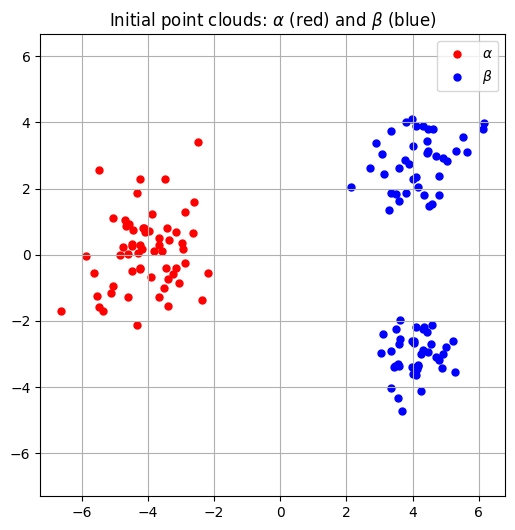

In [3]:
plt.figure(figsize=(6, 6))
plt.scatter(X[0, :].numpy(), X[1, :].numpy(), c='red', s=25, label=r'$\alpha$')
plt.scatter(Y[0, :].numpy(), Y[1, :].numpy(), c='blue', s=25, label=r'$\beta$')
plt.title('Initial point clouds: $\\alpha$ (red) and $\\beta$ (blue)')
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.show()

Code implementing the MMD distance by first computing the pairwise distance matrices.

In [4]:
def pairwise_distances(X_pts, Y_pts, eps=1e-8):
  diff = X_pts[:, None, :] - Y_pts[None, :, :]  # (N, M, d)
  sq_norm = (diff ** 2).sum(dim=-1)  # (N, M)
  D = torch.sqrt(sq_norm + eps)
  return D

def mmd2(X_mat, Y_mat, p=1.0):
  X_pts = X_mat
  Y_pts = Y_mat
  N = X_pts.shape[0]
  M = Y_pts.shape[0]
  # Pairwise distances
  D_xx = pairwise_distances(X_pts, X_pts)  # (N, N)
  D_yy = pairwise_distances(Y_pts, Y_pts)  # (M, M)
  D_xy = pairwise_distances(X_pts, Y_pts)  # (N, M)
  # Kernel evaluations k(x,y) = -||x-y||^p
  K_xx = -(D_xx ** p)
  K_yy = -(D_yy ** p)
  K_xy = -(D_xy ** p)
  term_xx = K_xx.sum() / (N * N)
  term_yy = K_yy.sum() / (M * M)
  term_xy = K_xy.sum() * (2.0 / (N * M))
  return term_xx + term_yy - term_xy

In [5]:
X_pts = X.t()  # (n, 2)
Y_pts = Y.t()  # (m, 2)

mmd_alpha_alpha = mmd2(X_pts, X_pts, p=p)
mmd_alpha_beta = mmd2(X_pts, Y_pts, p=p)

print('MMD(alpha, alpha) =', mmd_alpha_alpha.item())
print('MMD(alpha, beta)  =', mmd_alpha_beta.item())

MMD(alpha, alpha) = 0.0
MMD(alpha, beta)  = 12.187162399291992


We consider the functional
$$
  f(\mu) = \mathrm{MMD}(\mu,\beta)^2,
$$
initialized at $\mu_{t=0} = \alpha$.
Its Wasserstein gradient flow is given by the PDE
\begin{equation}
  \partial_t \mu_t - \nabla \cdot \bigl( v[\mu_t] \, \mu_t \bigr) = 0,
\end{equation}
where the Wasserstein gradient field is
\begin{equation}
  v[\mu](x) = \nabla_{\mathbb{R}^d} \frac{\delta f}{\delta \mu}(\mu)(x).
\end{equation}

In our case, one can show that
\begin{equation}
  \frac{1}{2} v[\mu](x)
  = \int \nabla_x k(x,y) \, \mathrm{d}\mu(y)
    - \int \nabla_x k(x,y) \, \mathrm{d}\beta(y).
\end{equation}
When $\mu$ is discrete,
\begin{equation}
  \alpha = \frac{1}{n} \sum_{i=1}^n \delta_{x_i},
\end{equation}
we encode the particle positions in a matrix
\begin{equation}
  X = (x_1, \dots, x_n) \in \mathbb{R}^{d \times n},
\end{equation}
and define
\begin{equation}
  F(X) := f(\alpha) = \mathrm{MMD}(\alpha, \beta)^2.
\end{equation}

The Wasserstein gradient flow induces the system of ODEs
\begin{equation}
  \dot{x}_i(t) = - \nabla_{x_i} F(X(t)), \qquad i=1,\dots,n.
\end{equation}

In discrete time, we approximate this with a gradient descent step of size $\tau>0$:
\begin{equation}
  x_i^{(k+1)} = x_i^{(k)} - \tau \, \nabla_{x_i} F\bigl(X^{(k)}\bigr),
\end{equation}
which we implement in PyTorch using automatic differentiation to compute the gradient.

First initialize the flow.

In [6]:
# Number of gradient descent steps and step size
num_steps = 4000
tau = 0.05*50
# Prepare tensors for gradient descent
X_curr = X_pts.clone().detach()  # shape (n, 2)
Y_target = Y_pts.clone().detach()  # fixed target cloud
# Bookkeeping array for trajectories
Xiter = torch.zeros(2, n, num_steps + 1)
Xiter[:, :, 0] = X_curr.t()  # store initial positions

Implementation of the gradient descent, store all the iterates for later display.

In [7]:
Xiter = torch.zeros(2, n, num_steps + 1)
Xiter[:, :, 0] = X_curr.t()  # store initial positions
for k in range(num_steps):
  X_curr.requires_grad_(True)
  # Define F(X) = MMD(mu, beta)^2, where mu is the empirical measure on X_curr
  F_X = mmd2(X_curr, Y_target, p=p)
  # Backpropagate to obtain gradients with respect to X_curr
  F_X.backward()
  with torch.no_grad():
      # Gradient descent step: X_{k+1} = X_k - tau * grad F(X_k)
      grad_X = X_curr.grad
      X_next = X_curr - tau * grad_X
  # Store the new positions (transpose back to shape (2, n))
  Xiter[:, :, k + 1] = X_next.t().detach()
  # Prepare next iteration
  X_curr = X_next.detach()

Display the particle trajectories. You will observe a clear pattern of convergence toward a region that is close to a global minimum, yet a small amount of fluctuation remains. With a finite number of particles, one should not expect exact convergence to the global minimizer $\alpha=\beta$. A few particles remain stuck in local configurations created by the discrete nature of the system.

A natural conjecture is that when the numbers $n,m$ of particles tend to $+\infty$ and one works with measures that have densities, and perhaps under some mild structural assumptions, the flow converges globally. This would echo the continuous setting analyzed by Chizat and Bach](https://arxiv.org/abs/1805.09545).

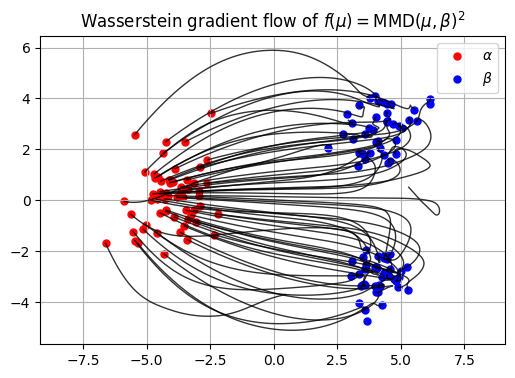

In [12]:
# Extract final positions of the particles in alpha
X_final = Xiter[:, :, -1]  # shape (2, n)
plt.figure(figsize=(6, 4))
# Plot the two clouds alpha and beta
plt.scatter(X[0, :].numpy(), X[1, :].numpy(), c='red', s=25, alpha=1, label=r'$\alpha$')
plt.scatter(Y[0, :].numpy(), Y[1, :].numpy(), c='blue', s=25, alpha=1, label=r'$\beta$')
# Plot particle trajectories in black
for i in range(n):
  traj = Xiter[:, i, :]  # shape (2, num_steps+1)
  plt.plot(traj[0, :].numpy(), traj[1, :].numpy(), 'k-', linewidth=1, alpha=.8)
plt.title('Wasserstein gradient flow of $f(\\mu) = \\mathrm{MMD}(\\mu,\\beta)^2$')
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.show()